## **0. Instalado y Carga de Librerías y Base**

In [ ]:
# Instalación de librerías
pip install -r ../services/ml_training/requirements.txt

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/642.7 kB ? eta -:--:--
     ---- ---------------------------------- 81.9/642.7 kB 2.3 MB/s eta 0:00:01
     ------------- ------------------------ 235.5/642.7 kB 3.6 MB/s eta 0:00:01
     ----------------------- -------------- 399.4/642.7 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 642.7/642.7 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/42.9 kB ? eta

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# Carga de Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import missingno as msno # poner en requirements.txt si se usa


In [47]:
# Carga de Base de datos

# Configuración Visual Profesional
plt.style.use('ggplot') #nuevo
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None) # Para ver todas las columnas en los describe()

# ==============================================================================
# 0. CARGA DE DATOS (Input del ETL)
# ==============================================================================
INPUT_FILE = '../services/ingestion/data_drop/fbref_big5_players_24_25_clean.csv'

try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ BASE CARGADA: {df.shape[0]} registros | {df.shape[1]} variables")
except FileNotFoundError:
    # Fallback local
    df = pd.read_csv('fbref_big5_players_24_25_clean.csv')
    print(f"✅ BASE CARGADA (LOCAL): {df.shape[0]} registros")

df.head(101)



✅ BASE CARGADA: 3006 registros | 150 variables


,player_name,nation,main_position_group,squad,league_id,age,record_type,rank,born,matches_played,starts,minutes_played,nineties,goals,assists,goals_assists,non_penalty_goals,pk_goals,pk_attempts,yellow_cards,red_cards,xg,npxg,xag,npxg_plus_xa,progressive_carries,progressive_passes,progressive_runs,non_penalty_goals_assists,expected_goals_assists,shots_total,shots_on_target,shots_on_target_pct,shots_p90,shots_on_target_p90,goals_per_shot,goals_per_sot,avg_shot_distance,free_kick_shots,npxg_per_shot,goals_minus_xg,np_goals_minus_npxg,passes_completed,passes_attempted,pass_completion_pct,pass_total_distance,pass_progressive_distance,xa,assists_minus_xa,key_passes,passes_final_third,passes_penalty_area,crosses_penalty_area,passes_live,passes_dead,passes_through_balls,passes_switches,passes_crosses,passes_throw_ins,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,offsides,blocks,sca,sca_p90,sca_pass_live,sca_pass_dead,sca_dribble,fouls_drawn,sca_defense,gca,gca_p90,tackles_total,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,challenge_tackles_pct,challenges_lost,blocks_passes,interceptions,tackles_interceptions,clearances,errors_leading_to_goal,touches,touches_def_pen_area,touches_att_pen_area,dribbles_completed,dribble_success_pct,dribbles_tackled,dribbles_tackled_pct,carries,carries_penalty_area,miscontrols,dispossessed,passes_received,minutes_per_match,minutes_pct,minutes_per_start,matches_completed,matches_subbed_in,minutes_per_sub,unused_sub,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_p90,plus_minus_on_off,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_p90,second_yellow_card,fouls_committed,pk_won,pk_conceded,own_goals,ball_recoveries,aerials_won,aerials_won_pct,goals_against,goals_against_p90,shots_on_target_against,saves,save_pct,wins,draws,losses,clean_sheets,clean_sheet_pct,pk_allowed,pk_saved,pk_missed,psxg,psxg_per_sot,psxg_plus_minus,gk_passes_attempted_launch,gk_throws,launch_pct,avg_pass_length,gk_crosses_faced,crosses_stopped,crosses_stopped_pct,def_actions_outside_box,def_actions_outside_box_p90,avg_keeper_sweeper_dist,team_order
0,Max Aarons,ENG,DF,Bournemouth,Premier League,24.0,Parcial,1,2000.0,3,1,86,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,8,3,0.00,0.00,0,0,0.0,0.00,0.00,0.00,0.00,0.0,0,0.00,0.0,0.0,50,63,79.4,887,361,0.0,0.0,0,8,0,0,51,12,0,0,2,10,0,0,0,0,0,1,2,2.09,2,0,0,0,0,0,0.00,2,2,1,1,0,100.0,0,2,1,3,0,0,73,2,0,0,0.0,1,50.0,41,0,1,0,40,29.0,2.5,61.0,0,2,13.0,11,0.67,2,0,2,2.09,1.82,2.3,0.3,2.0,2.12,0,0,0,0,0,7,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1
1,Max Aarons,ENG,DF,Valencia,La Liga,24.0,Parcial,2,2000.0,4,1,120,1.3,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0,6,10,0.00,0.02,0,0,0.0,0.00,0.00,0.00,0.00,0.0,0,0.00,0.0,0.0,47,66,71.2,705,190,0.0,0.0,1,2,0,0,54,12,0,0,5,11,0,0,0,0,0,1,1,0.75,1,0,0,0,0,0,0.00,4,4,2,2,0,80.0,1,1,0,4,3,0,85,1,0,1,25.0,2,50.0,46,0,3,1,49,30.0,3.5,73.0,0,3,16.0,14,0.75,1,3,-2,-1.50,-1.28,1.5,3.7,-2.3,-1.69,0,0,0,0,0,7,2,66.7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2
2,Rodrigo Abajas,ESP,DF,Valencia,La Liga,21.0,Parcial,3,2003.0,1,1,65,0.7,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,2,3,0.00,0.10,1,0,0.0,1.38,0.00,0.00,0.00,24.5,0,0.07,-0.1,-0.1,17,29,58.6,268,110,0.0,0.0,0,0,0,0,21,8,0,0,1,8,0,0,0,0,0,2,0,0.00,0,0,0,0,0,0,0.00,3,2,2,1,0,100.0,0,1,1,4,0,0,36,1,1,1,100.0,0,0.0,13,1,0,2,16,65.0,1.9,65.0,0,0,0.0,8,0.00,1,2,-1,-1.38,-1.14,1.4,0.7,0.7,0.93,0,2,0,0,0,2,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1
3,James Abankwah,IRL,DF,Udinese,Serie A,20.0,Parcial,4,2004.0,6,0,88,1.0,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,4,1,0.00,0.06,1,0,0.0,1.02,0.00,0.00,0.00,15.0,0,0.06,-0.1,-0.1,36,46,78.3,614,206,0.0,0.0,0,2,0,0,45,1,0,0,0,0,0,0,0,0,0,0,1,1.02,1,0,0,0,0,0,0.00,4,2,4,0,0,66.7,1,1,1,5,3,0,65,8,2,0,0.0,0,0.0,29,1,1,3,34,15.0,2.6,0.0,0,6,

## **🟢 PARTE 1: ANÁLISIS MACRO**
Objetivo: Entender el terreno de juego global antes de mirar a los jugadores. Validar la calidad del dato y definir el contexto. Para ello se realizarán los siguiente cálculos:

#### 1. Auditoría de Integridad (Data Health)

    - Análisis estructural de la base
        Conclusión: La base de datos tiene 3006 filas x 150 columnas, de las cuales 80 son int64, 64 son float64 y 6 son object.
        No se encontraron errores derivados del ETL.

    - Errores provenientes del ETL
        Conclusión: Se hallaron y corrigieron valores faltantes en algunos jugadores, como ser edad, año de nacimiento y
        nacionalidad. Se realizó un análisis de los valores nulos. Su corrección re realizó directamente en el ETL.

    - Estudio de Nulidad de variables
        Conclusión: Las variables que presentan valores nulos son aquellas que representan porcentajes o métrica por 90
        minutos. Se eliminó la variable residual 'unkdown_p90' directamente del ETL ya que era ruidosa y prescindible. Aunque
        esta variable ya viene de base y fue el resultado de un scrapping erróneo, puede obtenerséla nuevamente (en la ingeniería
        de características puede volver a aparecer).
        Respecto a la Matriz Nulidad, los resultados confirman que los valores nulos son estructurales y no errores. Es decir, las filas
        borradas corresponden a "COMBINED" o los totales, y la correlación indica que las variables NaN siempre faltan juntas (porque pertecen a las filas "COMBINED"). 

    - Detección de Duplicados Ocultos
        Conclusión: No hay filas duplicadas. Incluso, la unicidad Jugador-Equipo es perfecta, es decir, no hay duplicación de jugadores
        por equipo (recordar que se decidió expandir en filas los casos en los que un jugador en la temporada 24-25 estuvo en 2 equipos).
        
#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)
    - Histograma de Minutos Jugados + Curva de Densidad
    - Distribución de Edad
    - Pareto del Juego
#### 3. Distribución Estadística Global (Univariada)
    - Test de Normalidad (Shapiro-Wilk) en métricas clave
    - Skewness (Asimetría) y Kurtosis

#### 1. Auditoría de Integridad (Data Health)

📐 Dimensiones del Dataset: 3006 filas x 150 columnas 



C:\Users\Admin\AppData\Local\Temp\ipykernel_1572\1938169847.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')


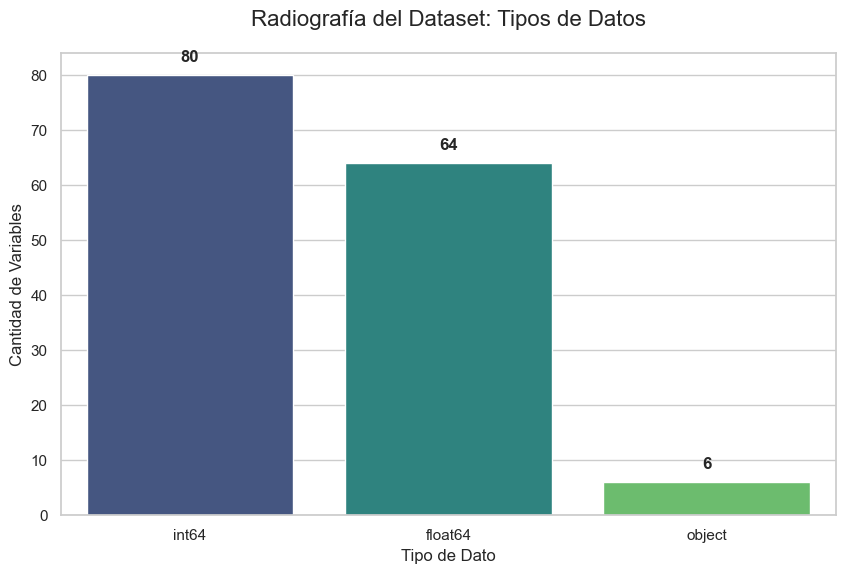

📊 Inventario Completo de Variables por Tipo:


,Tipo de Dato,Cantidad,Variables
0,int64,80,"rank, matches_played, starts, minutes_played, goals, assists, goals_assists, non_penalty_goals, pk_goals, pk_attempts, yellow_cards, red_cards, progressive_carries, progressive_passes, progressive_runs, shots_total, shots_on_target, free_kick_shots, passes_completed, passes_attempted, pass_total_distance, pass_progressive_distance, key_passes, passes_final_third, passes_penalty_area, crosses_penalty_area, passes_live, passes_dead, passes_through_balls, passes_switches, passes_crosses, passes_throw_ins, corner_kicks, corner_kicks_in, corner_kicks_out, corner_kicks_straight, offsides, blocks, sca, sca_pass_live, sca_pass_dead, sca_dribble, fouls_drawn, sca_defense, gca, tackles_total, tackles_won, tackles_def_3rd, tackles_mid_3rd, tackles_att_3rd, challenges_lost, blocks_passes, interceptions, tackles_interceptions, clearances, errors_leading_to_goal, touches, touches_def_pen_area, touches_att_pen_area, dribbles_completed, dribbles_tackled, carries, carries_penalty_area, miscontrols, dispossessed, passes_received, matches_completed, matches_subbed_in, unused_sub, on_goals_for, on_goals_against, plus_minus, second_yellow_card, fouls_committed, pk_won, pk_conceded, own_goals, ball_recoveries, aerials_won, team_order"
1,float64,64,"age, born, nineties, xg, npxg, xag, npxg_plus_xa, non_penalty_goals_assists, expected_goals_assists, shots_on_target_pct, shots_p90, shots_on_target_p90, goals_per_shot, goals_per_sot, avg_shot_distance, npxg_per_shot, goals_minus_xg, np_goals_minus_npxg, pass_completion_pct, xa, assists_minus_xa, sca_p90, gca_p90, challenge_tackles_pct, dribble_success_pct, dribbles_tackled_pct, minutes_per_match, minutes_pct, minutes_per_start, minutes_per_sub, points_per_match, plus_minus_p90, plus_minus_on_off, on_xg_for, on_xg_against, xg_plus_minus, xg_plus_minus_p90, aerials_won_pct, goals_against, goals_against_p90, shots_on_target_against, saves, save_pct, wins, draws, losses, clean_sheets, clean_sheet_pct, pk_allowed, pk_saved, pk_missed, psxg, psxg_per_sot, psxg_plus_minus, gk_passes_attempted_launch, gk_throws, launch_pct, avg_pass_length, gk_crosses_faced, crosses_stopped, crosses_stopped_pct, def_actions_outside_box, def_actions_outside_box_p90, avg_keeper_sweeper_dist"
2,object,6,"player_name, nation, main_position_group, squad, league_id, record_type"



ℹ️ Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 150 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    player_name                  3006 non-null   object 
 1    nation                       3006 non-null   object 
 2    main_position_group          3006 non-null   object 
 3    squad                        3006 non-null   object 
 4    league_id                    3006 non-null   object 
 5    age                          3006 non-null   float64
 6    record_type                  3006 non-null   object 
 7    rank                         3006 non-null   int64  
 8    born                         3006 non-null   float64
 9    matches_played               3006 non-null   int64  
 10   starts                       3006 non-null   int64  
 11   minutes_played               3006 non-null   int64  
 12   nineties             

In [ ]:
# Análisis estructural de la base
# 1. Verificación de Dimensiones
print(f"📐 Dimensiones del Dataset: {df.shape[0]} filas x {df.shape[1]} columnas \n")

#==========================================================================================================

# 2. Preparación datos para el gráfico de tipos de variables

# 2.1. Obtención de los tipos de datos
dtype_counts = df.dtypes.value_counts()

# 2.2. Configuración Visual
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# 2.3. Gráfico de Barras
barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')

# 2.4. Títulos y Etiquetas
plt.title('Radiografía del Dataset: Tipos de Datos', fontsize=16, pad=20)
plt.xlabel('Tipo de Dato', fontsize=12)
plt.ylabel('Cantidad de Variables', fontsize=12)

# 2.5. Añadir etiquetas de valor sobre las barras
for i, v in enumerate(dtype_counts.values):
    barplot.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.show()

#==========================================================================================================

# 3. Tabla completa de tipo de datos

# 3.1 Agrupación columnas por tipo de dato
dtype_summary = df.columns.to_series().groupby(df.dtypes).apply(list).reset_index()
dtype_summary.columns = ['Tipo de Dato', 'Lista de Variables']

# 3.2 Añadir conteo
dtype_summary['Cantidad'] = dtype_summary['Lista de Variables'].apply(len)

# 3.3 Formatear la lista completa (Sin truncar)

# Se unió toda la lista en un solo string separado por comas
dtype_summary['Variables'] = dtype_summary['Lista de Variables'].apply(lambda x: ', '.join(x))

# 3.4 Configuración para ver TODO el texto
pd.set_option('display.max_colwidth', None)

# 3.5 Mostrar tabla
print("📊 Inventario Completo de Variables por Tipo:")
display(dtype_summary[['Tipo de Dato', 'Cantidad', 'Variables']])


#==========================================================================================================

# 4. Información Técnica Completa (Memoria, Nulos, Dtypes)
print("\nℹ️ Información General del DataFrame:")
df.info(verbose=True, show_counts=True)

In [ ]:
# ==============================================================================
# ERRORES PROVENIENTES DEL ETL
# ==============================================================================
"""
    
print("\n" + "="*50)
print("1. VISIÓN GENERAL (HEALTH CHECK)")
print("="*50)

# A. Integridad de la Base (Nulos)
#    Aquí se crea específicamente un df que proporcione los valores nulos y otros tipos de datos más

def elite_audit(df):

    # Genera un reporte de salud básico del dataframe.
    
    # 1. Tipos de datos
    audit = pd.DataFrame(df.dtypes, columns=['Dtype'])
    
    # 2. Conteo de nulos y porcentaje
    audit['Nulos'] = df.isnull().sum()
    audit['% Nulos'] = (df.isnull().sum() / len(df)) * 100
    
    # 3. Valores únicos (Cardinalidad)
    audit['Unicos'] = df.nunique()
    
    # 4. Memoria (opcional, bueno para Big Data)
    audit['Memoria_KB'] = df.memory_usage(deep=True) // 1024
    
    
    return audit.sort_values(by='% Nulos', ascending=False)

# Ejecución de la auditoría

reporte = elite_audit(df)
display(reporte)

"""




1. VISIÓN GENERAL (HEALTH CHECK)


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
minutes_per_sub,float64,152,5.056554,62,23
aerials_won_pct,float64,152,5.056554,472,23
minutes_pct,float64,152,5.056554,874,23
minutes_per_start,float64,152,5.056554,52,23
save_pct,float64,152,5.056554,122,23
pass_completion_pct,float64,152,5.056554,416,23
dribbles_tackled_pct,float64,152,5.056554,350,23
shots_on_target_pct,float64,152,5.056554,278,23
dribble_success_pct,float64,152,5.056554,343,23
clean_sheet_pct,float64,152,5.056554,88,23


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

#   nulos_float = reporte[(reporte['% Nulos'] > 0) & (reporte['Dtype'] == 'float64')]
#   nulos_float



In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

# Quiero ver ahora si es que los valores nulos de las columnas que presentan valores NaN en columnas float, se concentran en algún "squad" específico, por ejemplo "COMBINADAS"

#   nulos_float_squads = df[df[nulos_float.index].isnull().any(axis=1)]['squad'].value_counts()
#   display(nulos_float_squads)

#   print('Las variables que quedaron con valores NaN son porcentajes "_pct", ' \
#   'o bien otras variables que no serían correcto sumarlas en las COMBINADAS. ' \
#   '\nSe tratará en la featuring engeneering esto. ')

# Ejemplo para ver que en las 

#   df[df[nulos_float.index].isnull().any(axis=1)].head(10)

In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

#====================================================================================

"""reporte_age_nulos = reporte.loc[reporte.index == 'age']
   display(reporte_age_nulos)

# Obtención del nombre de los jugadores que no tienen edad, año de nacimiento ni nacion registrada en el dataframe original df.

   jugadores_sin_datos = df[df['age'].isnull()][['player_name', 'age','born','nation']]
   display(jugadores_sin_datos)

# Como ya se corrigió el problema en el ETL entonces el problema fue solucionado

   if jugadores_sin_datos.shape[0]:
       print(f"Se encontraron {len(jugadores_sin_datos)} jugadores sin datos:")
       for g in jugadores_sin_datos:
           print("  -", ", ".join(g))
   else:
       print("No se encontraron jugadores sin datos de 'age', 'born' o 'nation'." \
       "\nTrabajo Completado!") """


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

# Busca columnas que tienen exactamente los mismos valores (incluyendo NaN en mismas posiciones)
#   columnas_duplicadas = []
#   _checked = set()
#   cols = df.columns.tolist()

""" for i, c in enumerate(cols):
    if c in _checked:
        continue
    grupo = [c]
    for c2 in cols[i+1:]:
        # Series.equals considera NaN en mismas posiciones como iguales
        if df[c].equals(df[c2]):
            grupo.append(c2)
            _checked.add(c2)
    if len(grupo) > 1:
        columnas_duplicadas.append(grupo)

# Resultado legible
if columnas_duplicadas:
    print(f"Se encontraron {len(columnas_duplicadas)} grupos de columnas duplicadas (por contenido):")
    for g in columnas_duplicadas:
        print("  -", ", ".join(g))
else:
    print("No se encontraron columnas duplicadas por contenido." \
    "\nTrabajo completado!") """

📊 Generando Auditoría de Nulos en 3 partes para 150 variables...
Amarillo = nulo, Violeta = dato


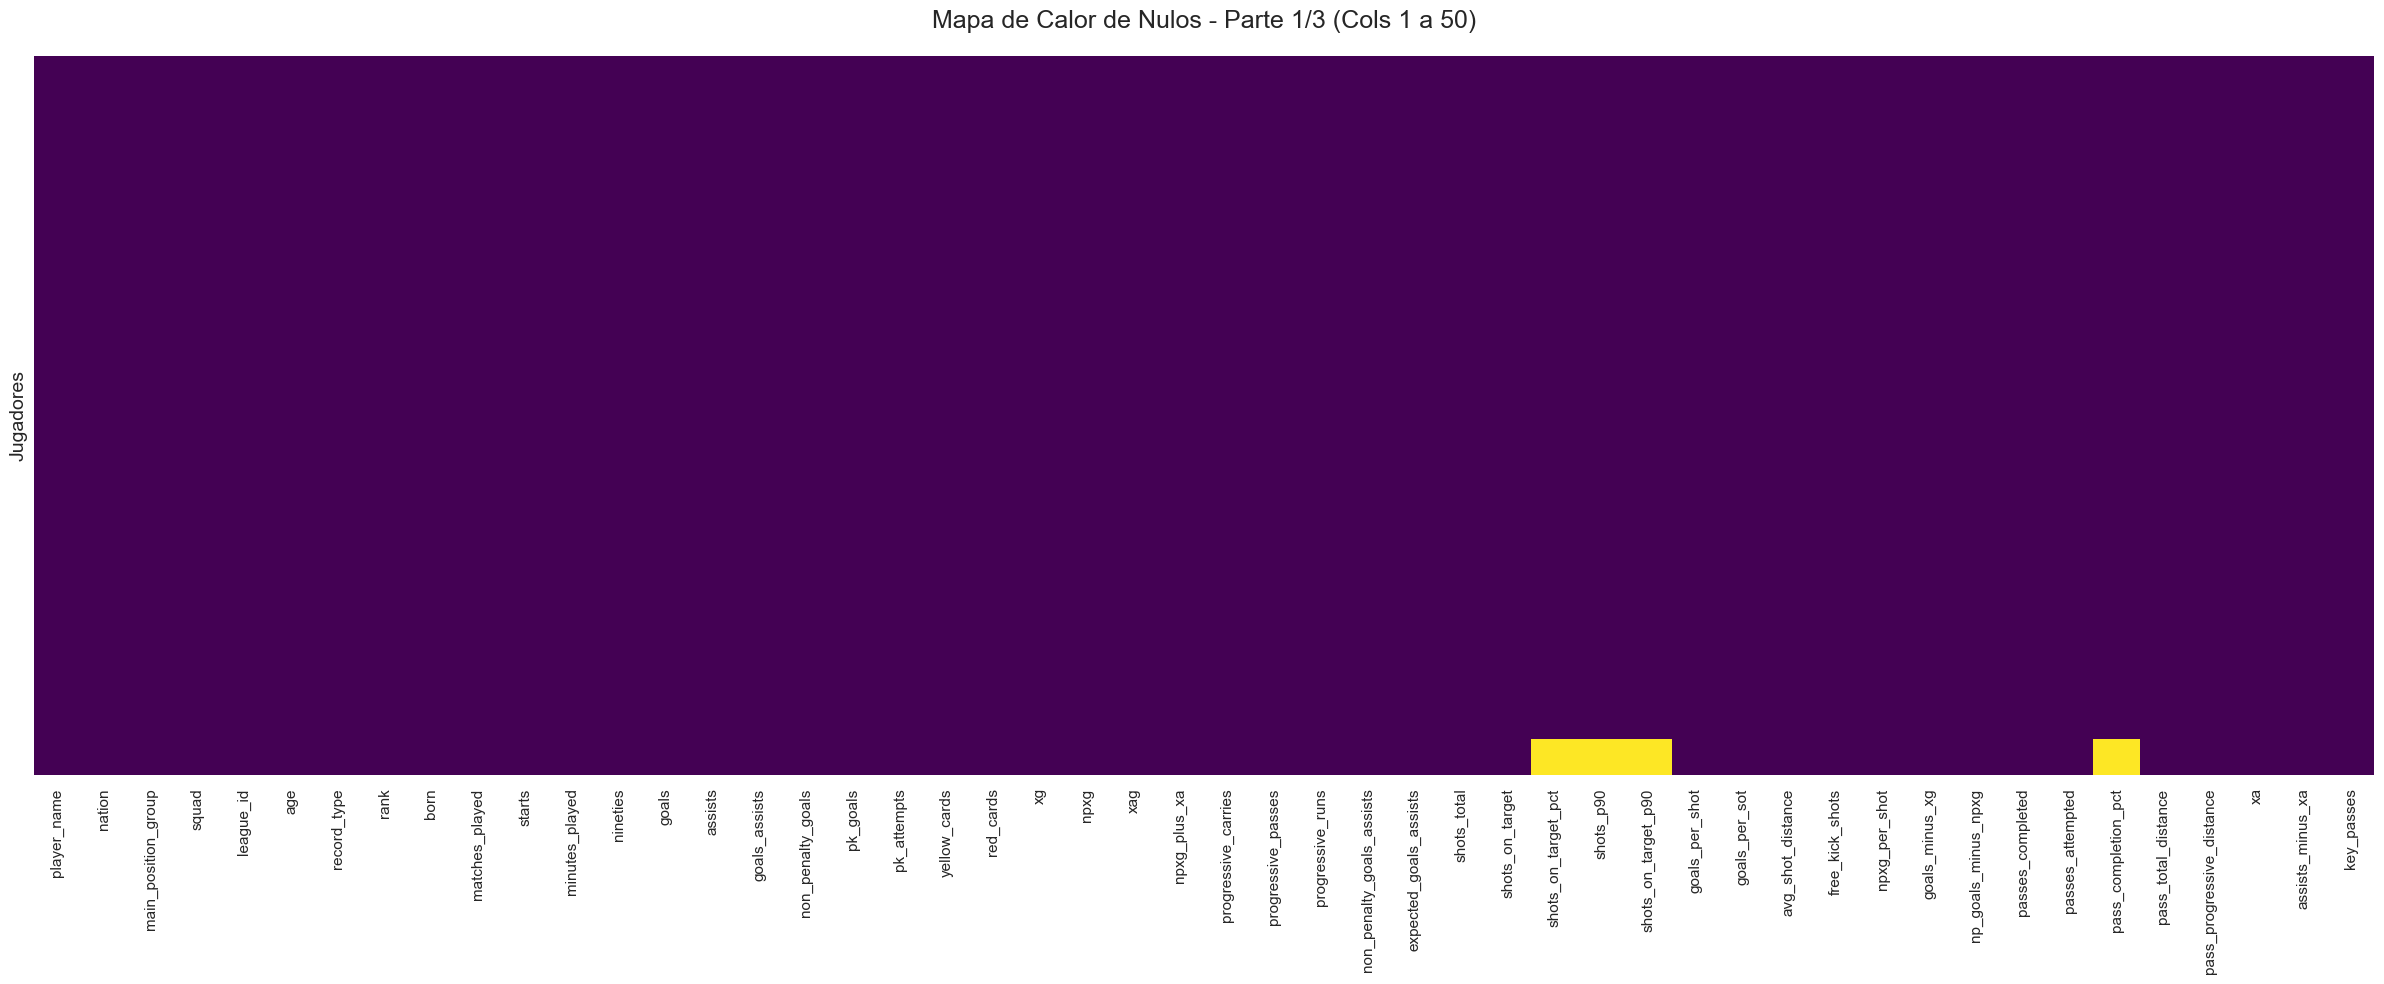

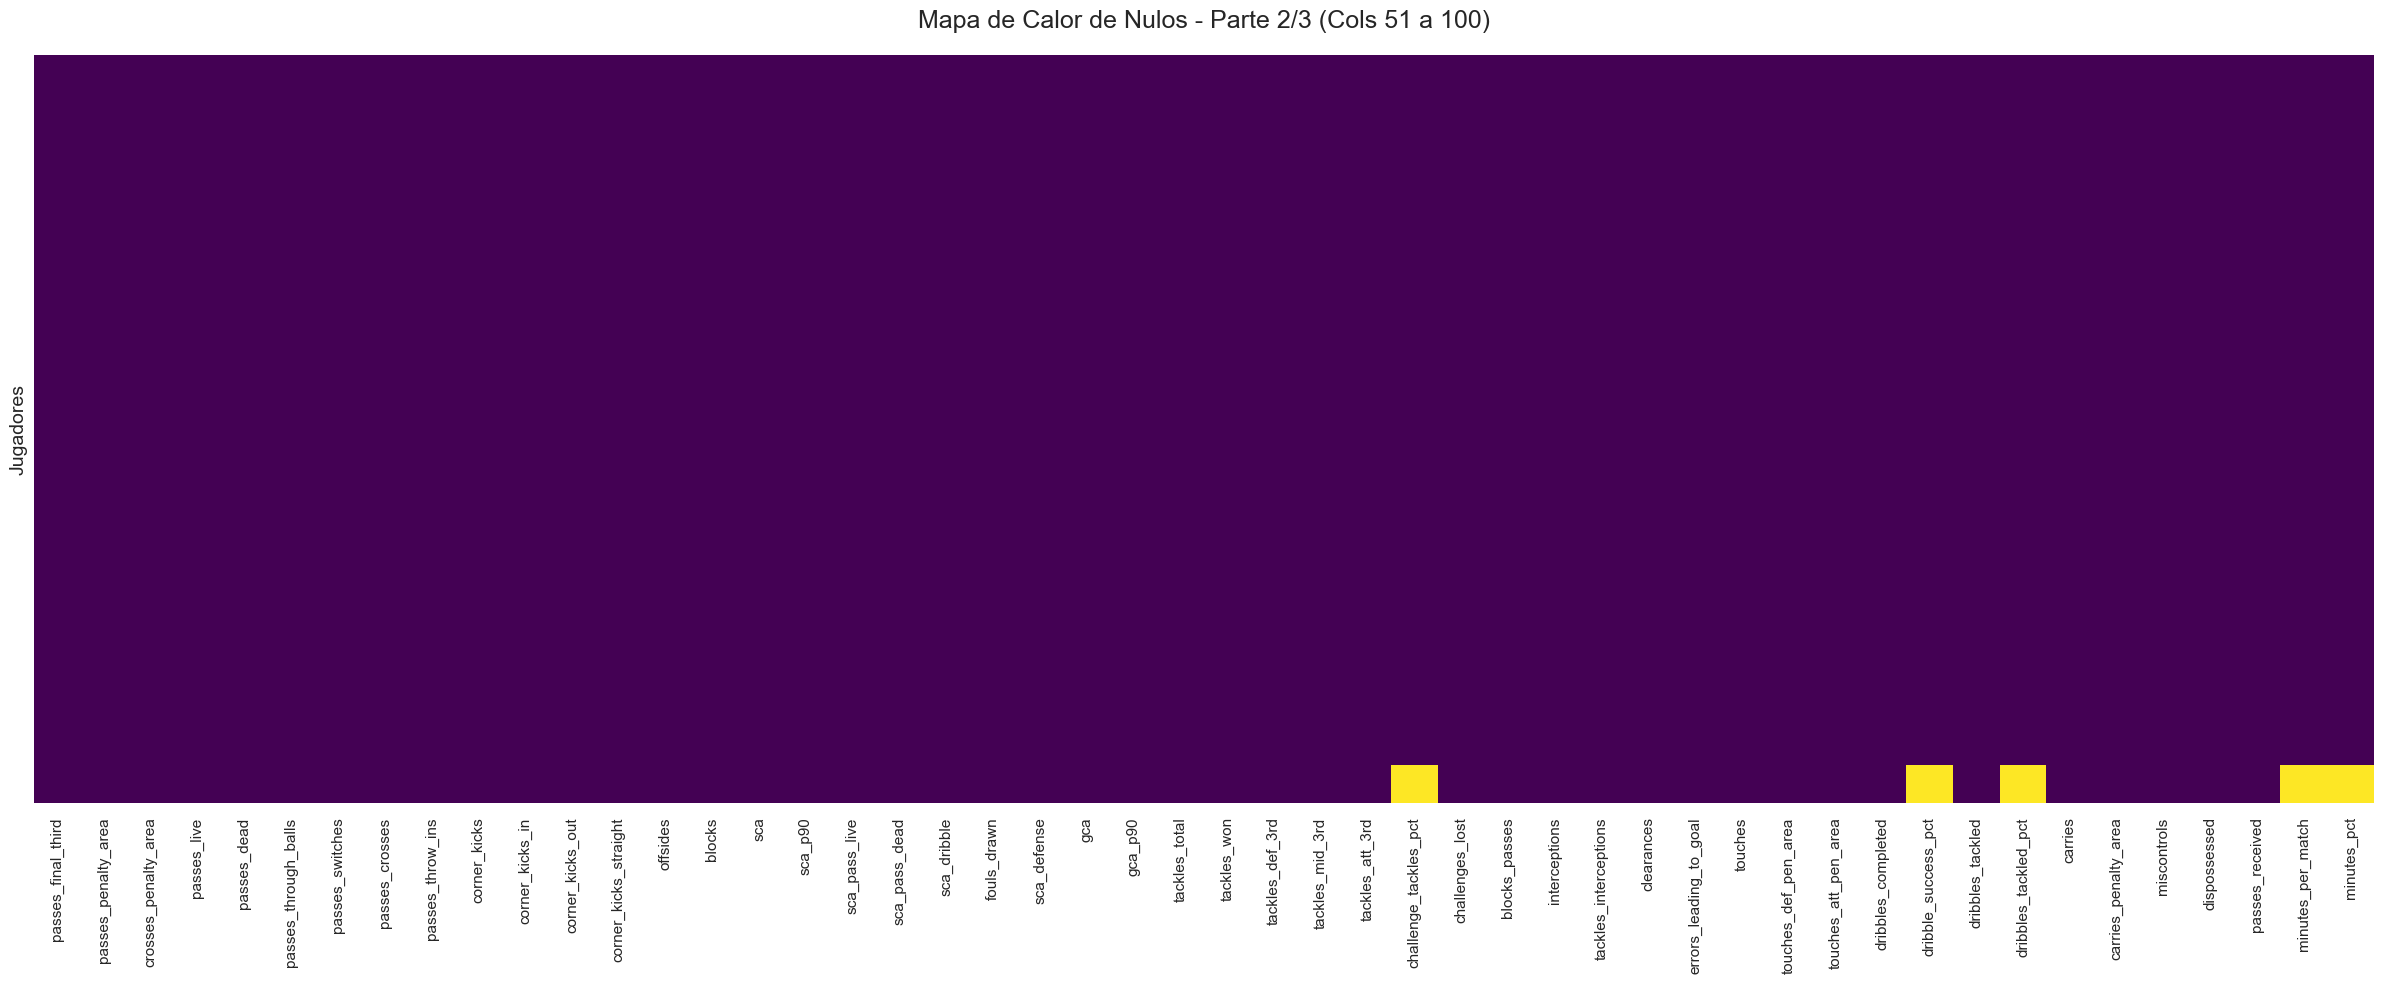

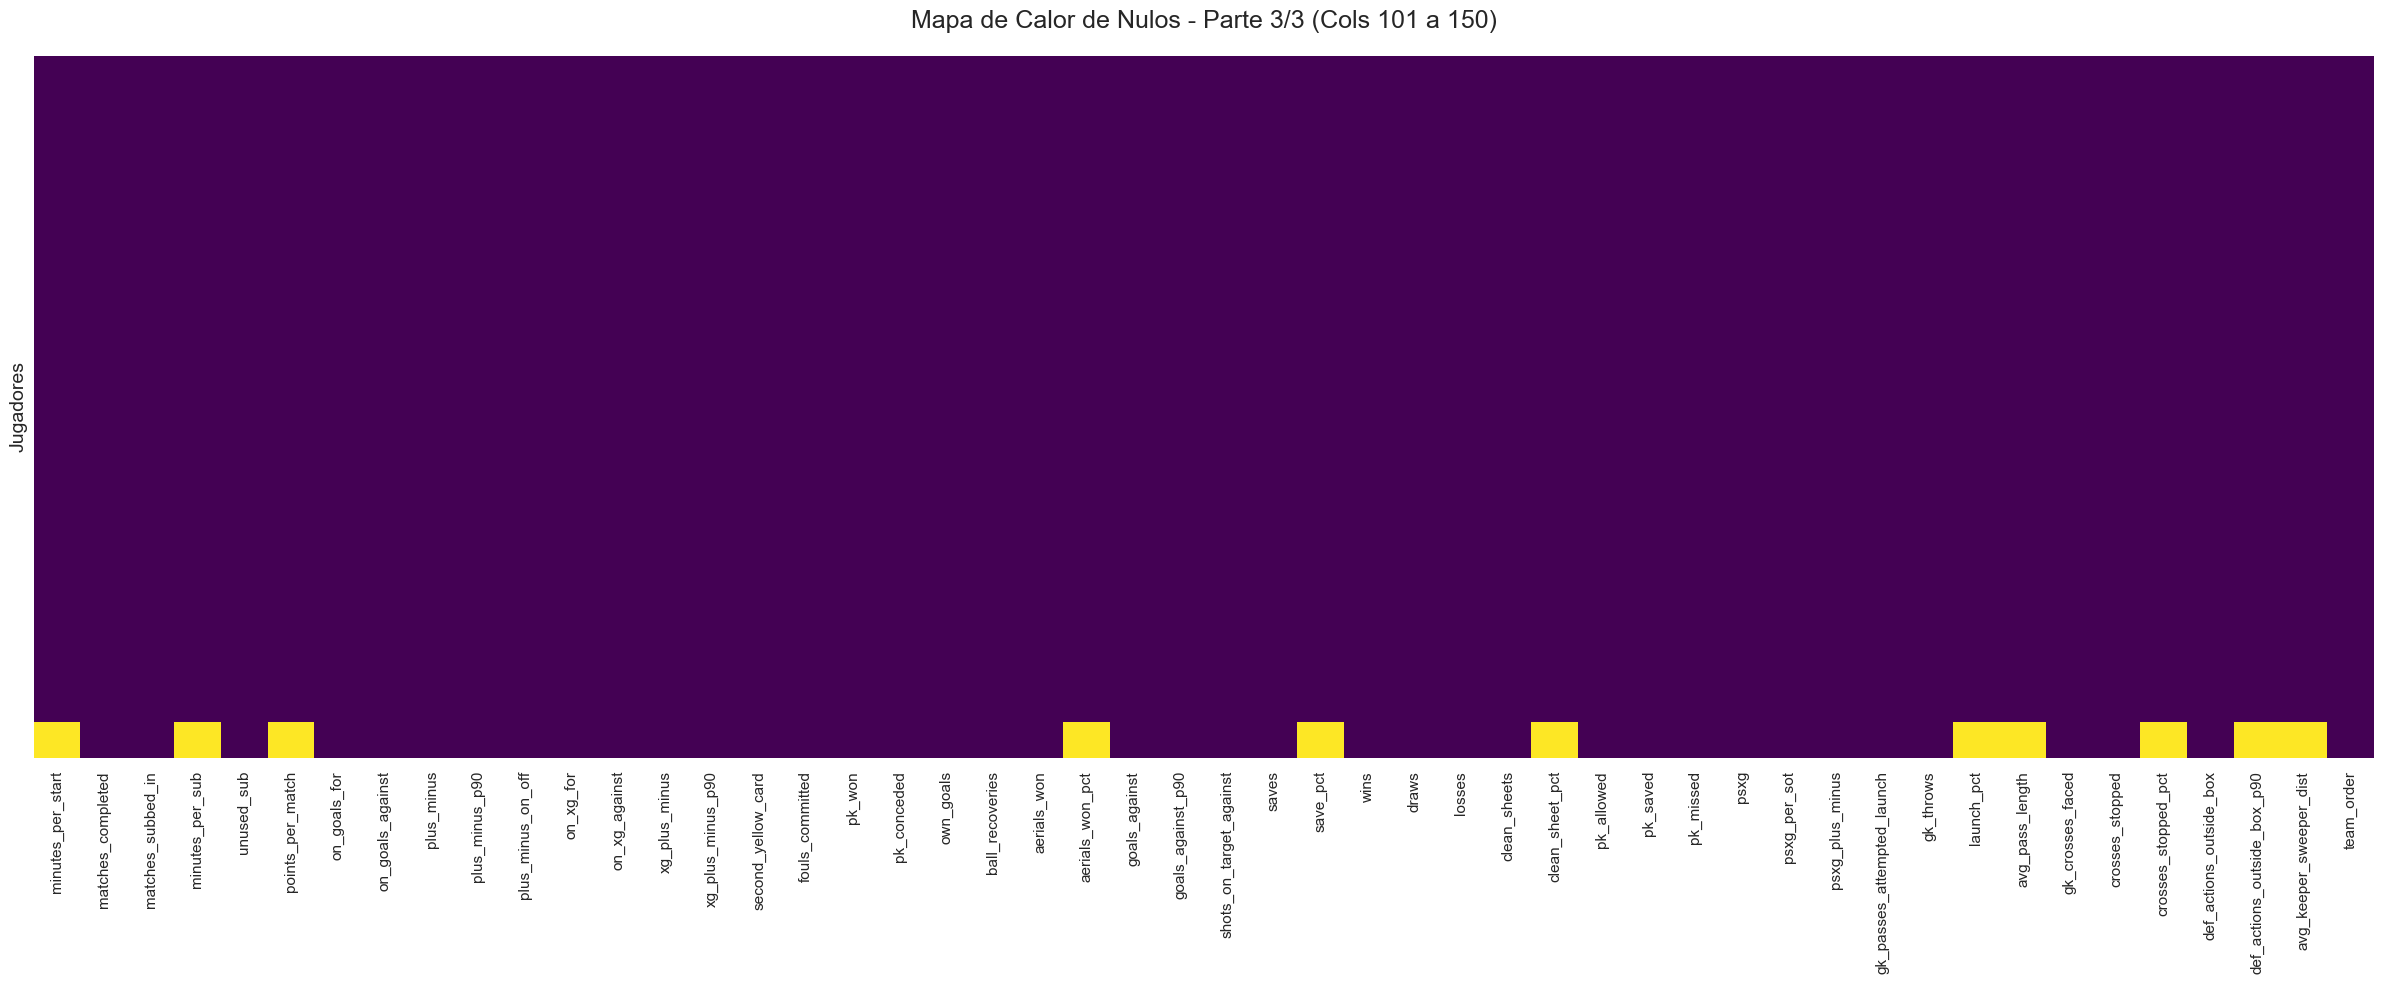

In [ ]:
# MAPAS DE CALOR DE NULOS

# 1. Configuración del gráfico

sns.set_theme(style="whitegrid")

# 2. Lógica de División (Chunking)
chunk_size = 50 # Cantidad de columnas por gráfico
total_cols = len(df.columns)
num_chunks = math.ceil(total_cols / chunk_size)

print(f"📊 Generando Auditoría de Nulos en {num_chunks} partes para {total_cols} variables...\nAmarillo = nulo, Violeta = dato")

# 3. Generación de Gráficos
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, total_cols)
    
    # Seleccionar subconjunto
    df_subset = df.iloc[:, start:end]
    
    # Crear Figura
    plt.figure(figsize=(24, 10)) # Ancho extra para leer los nombres
    
    # Mapa de Calor (Amarillo = Nulo, Violeta = Dato)
    sns.heatmap(df_subset.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    
    # Títulos y Etiquetas
    plt.title(f'Mapa de Calor de Nulos - Parte {i+1}/{num_chunks} (Cols {start+1} a {end})', fontsize=18, pad=20)
    plt.xticks(rotation=90, fontsize=11) # Rotar nombres para que se lean
    plt.ylabel('Jugadores', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Filas COMBINED: 152
Filas SINGLE: 2854



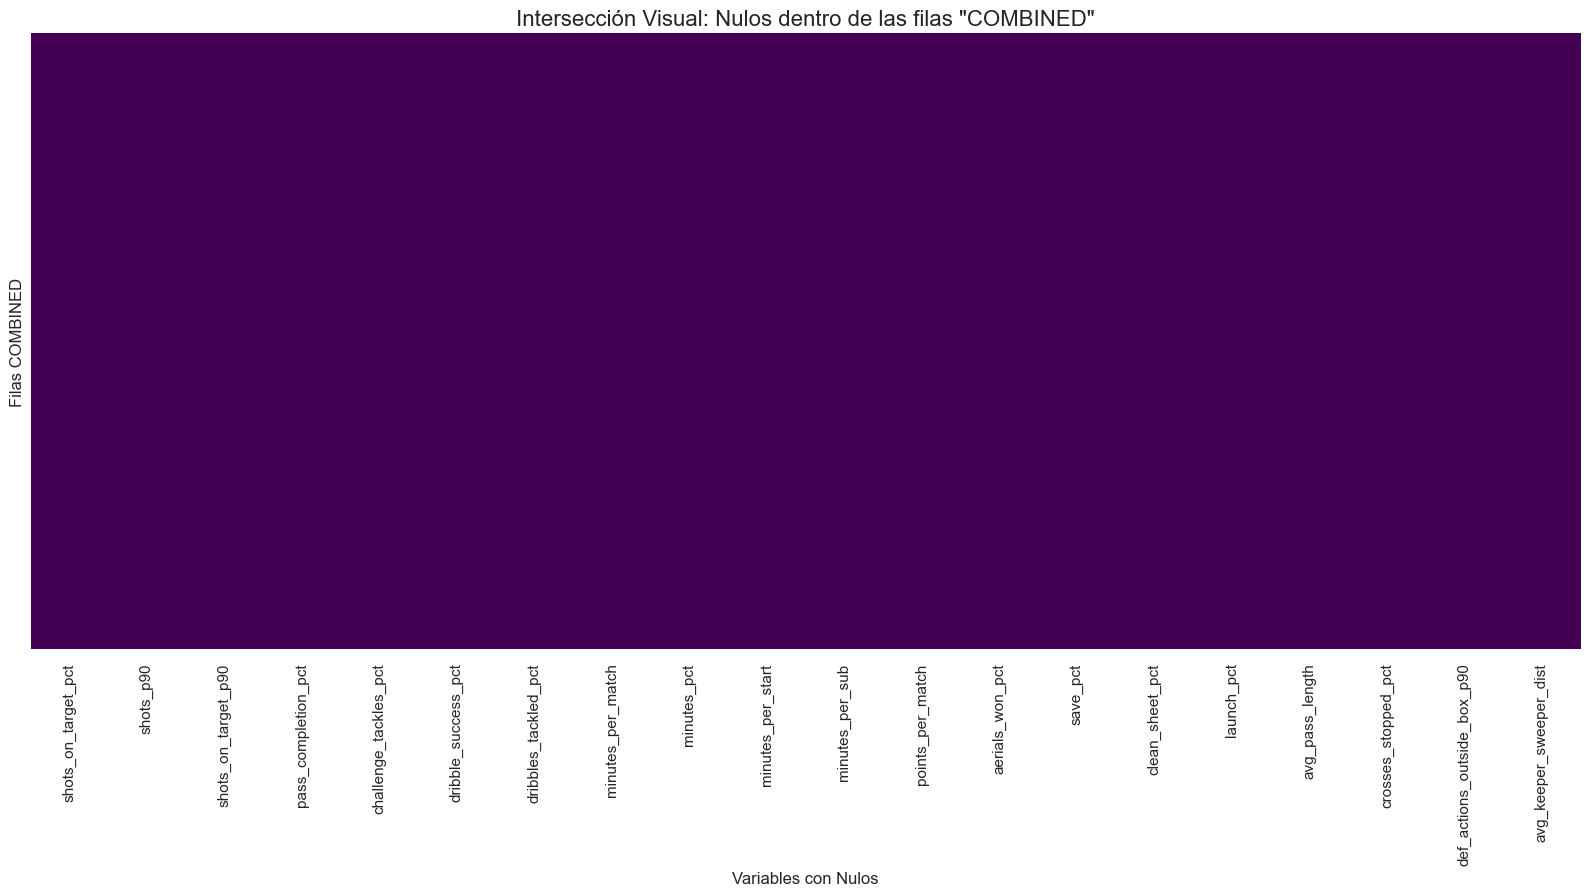



>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<
                             % Nulos en COMBINED  % Nulos en SINGLE
shots_on_target_pct                        100.0                0.0
crosses_stopped_pct                        100.0                0.0
avg_pass_length                            100.0                0.0
launch_pct                                 100.0                0.0
clean_sheet_pct                            100.0                0.0
save_pct                                   100.0                0.0
aerials_won_pct                            100.0                0.0
points_per_match                           100.0                0.0
minutes_per_sub                            100.0                0.0
minutes_per_start                          100.0                0.0
minutes_pct                                100.0                0.0
minutes_per_match                          100.0                0.0
dribbles_tackled_pct                   

In [ ]:
# Aquí se comprueba que los valores nulos se corresponden con los valores "COMBINED"

# 1. Separar el universo en dos: 'Combined' (Totales) vs 'Single' (Equipos individuales)
df_combined = df[df['squad'] == 'COMBINED']
df_single = df[df['squad'] != 'COMBINED']

print(f"Filas COMBINED: {len(df_combined)}")
print(f"Filas SINGLE: {len(df_single)}")
print('\n',"=" * 80)

# 2. Identificar columnas con Nulos
# Solo nos interesan las columnas que tienen algún dato faltante
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if not cols_with_nulls:
    print("¡No hay nulos en el dataset!")
else:
    # --- VISUALIZACIÓN 1: MAPA DE CALOR SOLO DE 'COMBINED' ---
    plt.figure(figsize=(20, 8))
    # Filtramos el DF para ver solo filas COMBINED y solo columnas problemáticas
    sns.heatmap(df_combined[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Intersección Visual: Nulos dentro de las filas "COMBINED"', fontsize=16)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Filas COMBINED')
    plt.xticks(rotation=90)
    plt.show()

    # --- ANÁLISIS 2: COMPARATIVA NUMÉRICA (LA PRUEBA DE FUEGO) ---
    # Calculamos el % de nulos en cada grupo
    null_pct_combined = df_combined[cols_with_nulls].isnull().mean() * 100
    null_pct_single = df_single[cols_with_nulls].isnull().mean() * 100

    # Creamos un DataFrame para comparar
    comparison = pd.DataFrame({
        '% Nulos en COMBINED': null_pct_combined,
        '% Nulos en SINGLE': null_pct_single
    })
    
# 3. Filtramos para ver donde la diferencia es drástica (Hipótesis del ETL)

# Mostramos columnas donde Combined es 100% nulo pero Single tiene datos
print('\n',"=" * 80)
print("\n>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<")
pd.set_option('display.max_rows', None)
print(comparison[comparison['% Nulos en COMBINED'] > 90].sort_values('% Nulos en SINGLE'))

nulos = reporte[(reporte['% Nulos'] > 0)]

print('\n',"=" * 80)

print("\nEsta es la cantidad de columnas con valores nulos:", len(nulos))

In [ ]:
# Aquí se vió que era lo que contenía la columna 'unkdown_p90'. Su correción se aplicó al ETL.

#df_residual = df['unknown_p90']
#df_residual.unique()

"""
Al ver los valores (entre -2.72 y +1.17) y compararlos con las métricas de arqueros en FBref, 
esta columna es casi con seguridad PSxG+/- /90 (Post-Shot Expected Goals minus Goals Allowed per 90 minutes). 
Es decir, "cuántos goles extra salvó el arquero por partido.
Dado que ya tenemos la columna PSxG+/- (total), tener el "per 90" es redundante porque podemos calcularlo 
nosotros mismos (PSxG+/- dividido 90s). Por lo tanto, se eliminará esta columna. 
Para eliminarla se hará quitará la columna directamente en el ETL.
"""

KeyError: 'unknown_p90'

⚠️ Se encontraron 20 variables con datos faltantes.


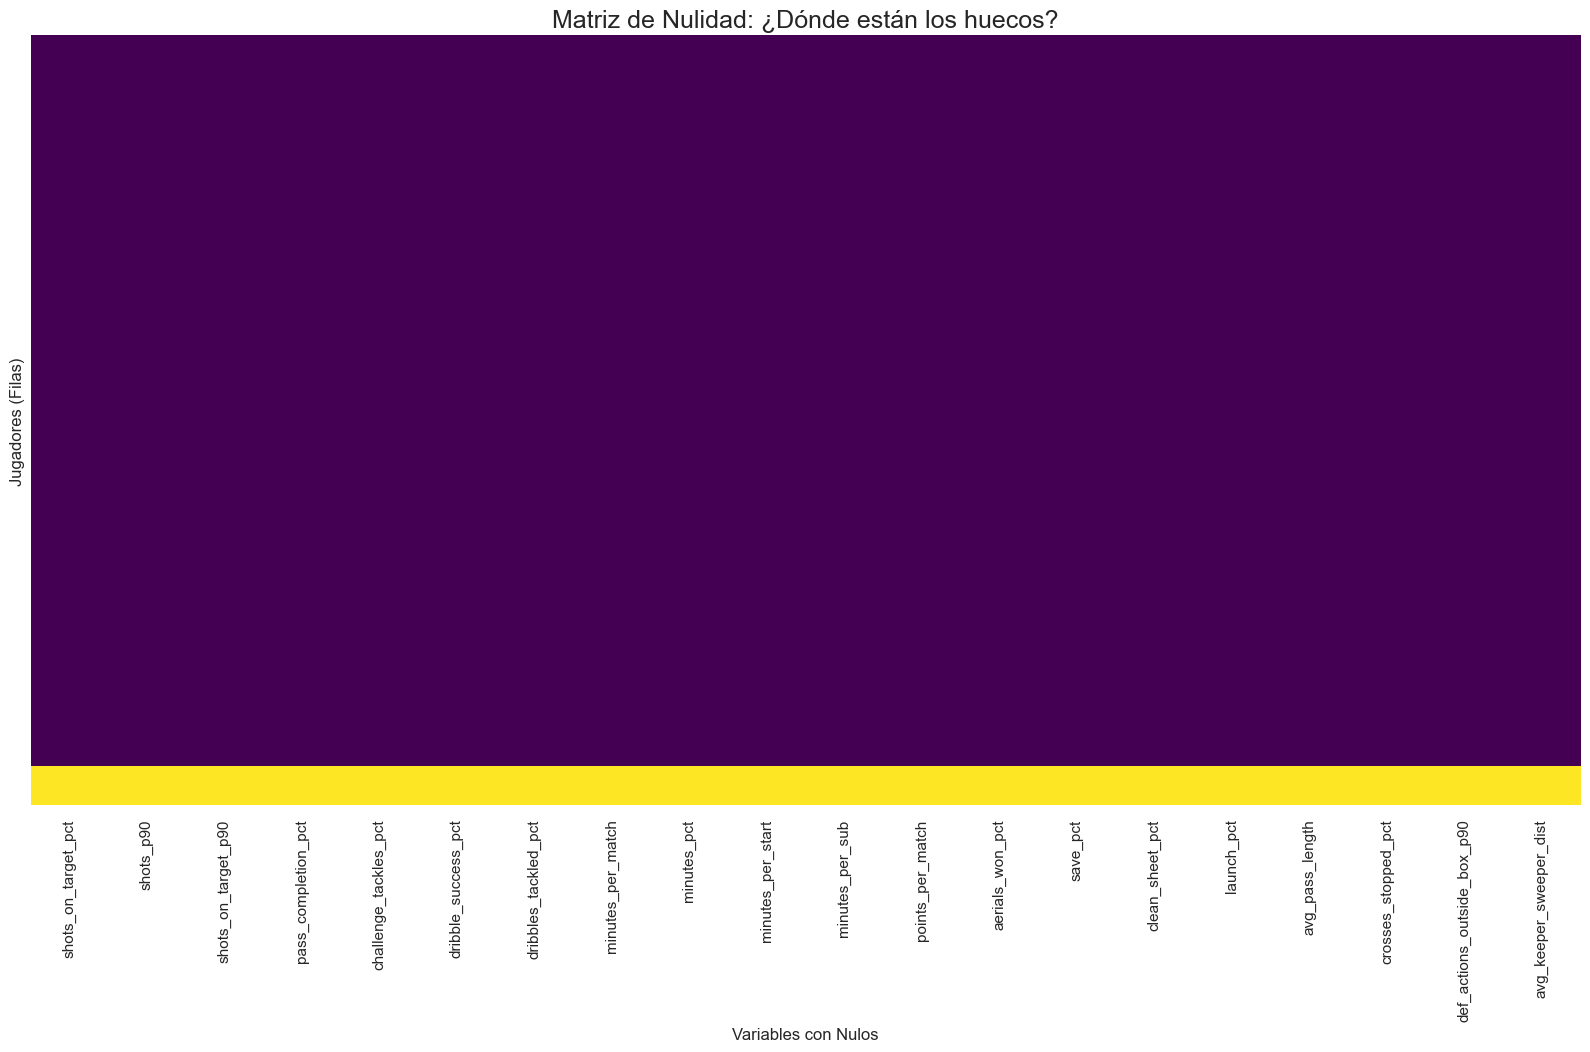

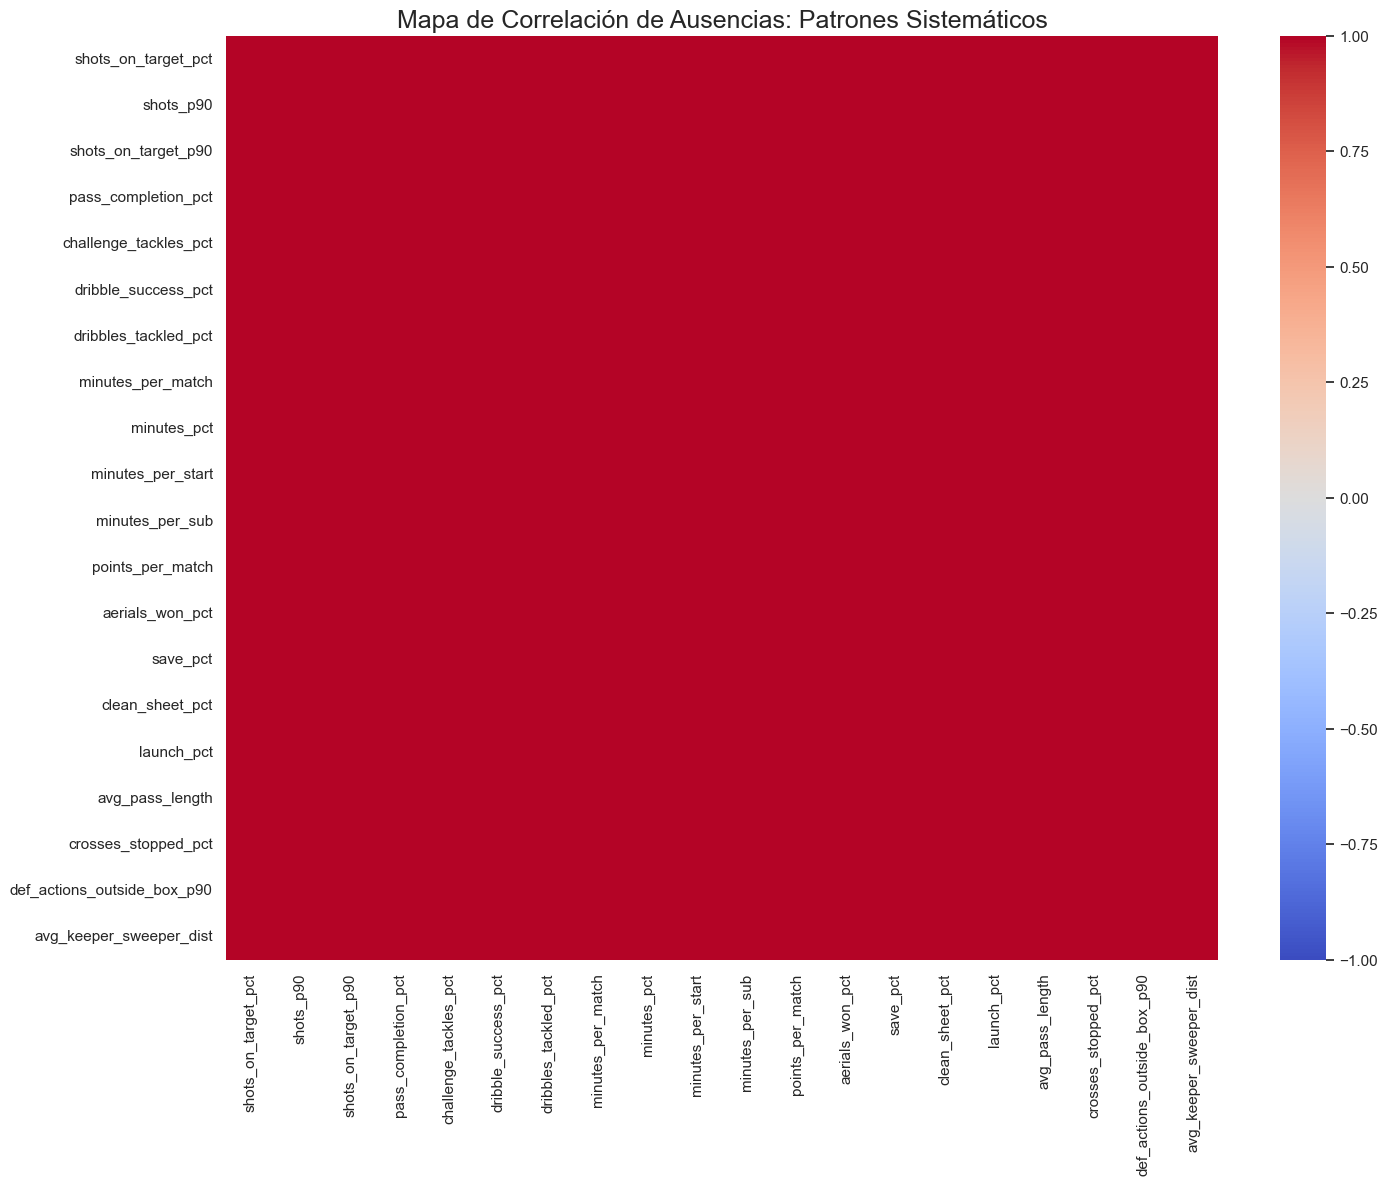

💡 INTERPRETACIÓN:
1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).
2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).


In [ ]:
# Matriz de Nulidad (Heatmap de ausencias)

# 1. Filtrar solo columnas que tienen algún nulo
# (Si graficamos las 150 columnas, no se verá nada. Nos enfocamos en el problema)
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if len(cols_with_nulls) == 0:
    print("✅ ¡Increíble! No hay un solo valor nulo en todo el dataset.")
else:
    print(f"⚠️ Se encontraron {len(cols_with_nulls)} variables con datos faltantes.")
    
    # --- GRÁFICO A: MATRIZ DE NULIDAD (Missingness Matrix) ---
    # Esto nos muestra DÓNDE están los nulos.
    # Eje X: Variables. Eje Y: Jugadores. Color: Dato faltante.
    plt.figure(figsize=(20, 10))
    sns.heatmap(df[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Matriz de Nulidad: ¿Dónde están los huecos?', fontsize=18)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Jugadores (Filas)')
    plt.xticks(rotation=90)
    plt.show()

    # --- GRÁFICO B: CORRELACIÓN DE NULIDAD (Systematic Pattern) ---
    # Esto responde: "Si falta A, ¿también falta B?"
    # 1 = Correlación perfecta (si falta uno, falta el otro).
    plt.figure(figsize=(16, 12))
    nullity_corr = df[cols_with_nulls].isnull().corr()
    
    sns.heatmap(nullity_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Mapa de Correlación de Ausencias: Patrones Sistemáticos', fontsize=18)
    plt.show()

    # Insight Automático:
    print("💡 INTERPRETACIÓN:")
    print("1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).")
    print("2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).")

In [ ]:
# ANALISIS DE DUPLICADOS

print(f"📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD")
print("-" * 40)

# 1. Análisis de Duplicados Totales (Filas idénticas)
total_dups = df.duplicated().sum()
print(f"1. Filas Totalmente Duplicadas: {total_dups}")
if total_dups == 0:
    print("   ✅ APROBADO: No hay filas repetidas.")
else:
    print(f"   ❌ ALERTA: Se encontraron {total_dups} duplicados exactos.")

# 2. Análisis de Llave Primaria (Constraint Check)

# En este dataset, un jugador no puede aparecer dos veces en el mismo equipo
pk_cols = ['player_name', 'squad']
pk_dups = df.duplicated(subset=pk_cols).sum()

print(f"\n2. Duplicados de Llave Primaria {pk_cols}: {pk_dups}")
if pk_dups == 0:
    print("   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.")
else:
    print(f"   ❌ FALLO: Hay {pk_dups} violaciones de integridad referencial.")
    # Mostrar culpables
    print(df[df.duplicated(subset=pk_cols, keep=False)].sort_values('player_name'))

📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD
----------------------------------------
1. Filas Totalmente Duplicadas: 0
   ✅ APROBADO: No hay filas repetidas.

2. Duplicados de Llave Primaria ['player_name', 'squad']: 0
   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.


#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)

In [ ]:
# ==============================================================================
# PARTE 2: ANÁLISIS INTRA-GRUPAL (POR POSICIONES)
# ==============================================================================
print("\n" + "="*50)
print("2. ANÁLISIS INTRA-GRUPAL (SEGREGACIÓN POSICIONAL)")
print("="*50)

# Filtramos "ruido" para este análisis (Jugadores > 450 min)
df_core = df[df['minutes_played'] > 450].copy()
print(f"Analizando subconjunto de {len(df_core)} jugadores con > 450 minutos.")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Grupo Delanteros (FW) - Eficiencia
sns.boxplot(data=df_core, x='main_position_group', y='goals', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribución de GOLES por Posición')

# B. Grupo Creativos (MF) - Progresión
sns.boxplot(data=df_core, x='main_position_group', y='progressive_passes', ax=axes[0,1], palette='mako')
axes[0,1].set_title('Distribución de PASES PROGRESIVOS por Posición')

# C. Grupo Defensivo (DF) - Destrucción
sns.boxplot(data=df_core, x='main_position_group', y='tackles_total', ax=axes[1,0], palette='rocket')
axes[1,0].set_title('Distribución de TACKLES por Posición')

# D. Grupo Porteros (GK) - Trabajo
# Filtramos solo GK para que el gráfico no quede vacío en otras posiciones
df_gk = df_core[df_core['main_position_group'] == 'GK']
if not df_gk.empty:
    sns.violinplot(data=df_gk, y='saves', ax=axes[1,1], color='cyan')
    axes[1,1].set_title('Densidad de ATAJADAS (Solo Arqueros)')
else:
    axes[1,1].text(0.5, 0.5, 'Sin datos de GK suficientes', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# PARTE 3: ANÁLISIS INTER-GRUPOS Y CONSISTENCIA (MICRO)
# ==============================================================================
print("\n" + "="*50)
print("3. ANÁLISIS DE CONSISTENCIA Y RELACIONES (CRUCE DE VARIABLES)")
print("="*50)

# A. Correlaciones Tácticas (Heatmap)
# ¿Se mueven juntas las métricas defensivas?
cols_def = ['tackles_total', 'interceptions', 'blocks', 'ball_recoveries', 'yellow_cards']
corr_mat = df_core[cols_def].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('3.A. Matriz de Coherencia Defensiva', fontsize=14, fontweight='bold')
plt.show()

# B. Scatter de Anomalías: Goles vs xG
# Buscamos "Overperformers" (Talento/Suerte) y "Underperformers" (Mala racha)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_core, x='xg', y='goals', hue='main_position_group', alpha=0.6, palette='deep')
# Línea de identidad
limit = max(df_core['goals'].max(), df_core['xg'].max())
plt.plot([0, limit], [0, limit], 'r--', alpha=0.5, label='Rendimiento Esperado')
plt.title('3.B. Consistencia Ofensiva: Realidad vs Expectativa', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# C. Detección de Anomalías Específicas (El caso del "Portero Loco")
# Pregunta del usuario: ¿Hay porteros con muchas tarjetas amarillas?
print("\n--- 3.C. Detección de Anomalías: Porteros Indisciplinados ---")
gks_cards = df_core[df_core['main_position_group'] == 'GK'][['player_name', 'squad', 'yellow_cards']].sort_values('yellow_cards', ascending=False)
top_bad_boys = gks_cards.head(5)

if not top_bad_boys.empty:
    print("Top 5 Arqueros con más amarillas:")
    print(top_bad_boys)
    
    # Gráfico rápido si hay datos
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top_bad_boys, x='yellow_cards', y='player_name', palette='Reds_r')
    plt.title('Anomalía: Arqueros con más Tarjetas Amarillas')
    plt.show()
else:
    print("No se encontraron arqueros con tarjetas en el corte seleccionado.")

print("\n" + "="*50)
print("✅ EDA FINALIZADO. DIAGNÓSTICO COMPLETO.")
print("="*50)